In [120]:
## Packages
# system
import os
# data wrangling
import numpy as np
import pandas as pd
from scipy import stats
from dfply import *
import statistics
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Settings
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', 1000)

### Data Import

In [121]:
%%time
## read in data 
raw_path = os.path.join('../../../', 'raw_data/')
processed_path = os.path.join('../', 'processed_data/')
# bene = pd.read_csv(os.path.join(raw_path, 'Train_Beneficiarydata-1542865627584.csv'))
# flag = pd.read_csv(os.path.join(raw_path, 'Train-1542865627584.csv'))
df_ip = pd.read_csv(os.path.join(processed_path,'df_ip.csv'), index_col = 0)
df_op = pd.read_csv(os.path.join(processed_path,'df_op.csv'), index_col = 0)

CPU times: user 4.07 s, sys: 642 ms, total: 4.71 s
Wall time: 5.09 s


### imputation

In [122]:
# check no code is currently 0
print(df_ip[df_ip.columns[df_ip.columns.str.contains(pat = 'Cdoe')]].eq(0).any())

# # fill NA codes with 0
code_col_ip = df_ip.columns[df_ip.columns.str.contains(pat = 'Code')]
df_ip[code_col_ip] = df_ip[code_col_ip].fillna(0)

code_col_op = df_op.columns[df_op.columns.str.contains(pat = 'Code')]
df_op[code_col_op] = df_op[code_col_op].fillna(0)

Series([], dtype: bool)


### codes

In [123]:
code = df_ip.columns[df_ip.columns.str.contains('Code')]
diagnosiscode = df_ip.columns[df_ip.columns.str.contains('DiagnosisCode_')]
procedurecode = df_ip.columns[df_ip.columns.str.contains('ProcedureCode_')]
print('diagnosis code', len(diagnosiscode))
print('procedure code', len(procedurecode))

diagnosis code 10
procedure code 6


### duplicated claims

In [124]:
# duplicated claims
code_for_duplicate = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2', 'ClmDiagnosisCode_3','ClmDiagnosisCode_4',
                      'ClmProcedureCode_1', 'ClmProcedureCode_2', 
                      'ClmAdmitDiagnosisCode']

code_for_duplicate = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
                      'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
                      'ClmProcedureCode_1', 'ClmAdmitDiagnosisCode'] # stablize for both IP & OP

# keep = first will mark all duplicates except the 1st occurrence
df_ip_duplicate = df_ip.duplicated(subset = code_for_duplicate, keep=False).sum()
print('inpatient claims', df_ip.shape[0], 'duplicate #', df_ip_duplicate, round(df_ip_duplicate/df_ip.shape[0], ndigits = 3))

df_op_duplicate = df_op.duplicated(subset = code_for_duplicate, keep=False).sum()
print('outpatient claims', df_op.shape[0], 'duplicate #', df_op_duplicate, round(df_op_duplicate/df_op.shape[0], ndigits = 3))

inpatient claims 40474 duplicate # 1433 0.035
outpatient claims 517737 duplicate # 229202 0.443


In [125]:
# duplicate claim dataframe
dup_ip = df_ip[df_ip.duplicated(subset = code_for_duplicate, keep=False)].sort_values(by = 'ClmDiagnosisCode_1')
dup_ip['group'] = dup_ip.groupby(code_for_duplicate).grouper.group_info[0] + 1
display(dup_ip.group.head())
# dup_ip_index = dup_ip.index.to_list()

22904    1
10448    1
23923    2
13514    2
11871    3
Name: group, dtype: int64

In [126]:
dup_ip.groupby('group').size().value_counts()

2    685
3     14
4      4
5      1
dtype: int64

In [127]:
# merge duplicated groups to df_ip
dup_ip_groups = dup_ip.group.to_frame()
df_ip = df_ip.merge(dup_ip_groups, how = 'left', right_index = True, left_index = True)
df_ip.group = df_ip.group.fillna(0)
# display(df_ip.head())

# flag whether a row in duplicated or not
df_ip['duplicated'] = np.where(df_ip.group.eq(0), False, True)
df_ip.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,ClaimDuration,HospitalDuration,TotalPaid,group,duplicated
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,0,0.0,0.0,0.0,0.0,0.0,0.0,1943-01-01,NaN,1,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,Yes,6,6,27068.0,0.0,False
1,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,0,7769.0,5849.0,0.0,0.0,0.0,0.0,1913-12-01,NaN,2,1,0,39,230,12,12,0,0,0,1,0,1,1,0,1,1,1,19000,1068,100,20,Yes,12,12,20068.0,0.0,False
2,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,0,9338.0,0.0,0.0,0.0,0.0,0.0,1922-10-01,NaN,1,1,0,39,600,12,12,1,1,1,1,1,1,1,0,0,1,1,17000,1068,1050,540,Yes,18,18,18068.0,0.0,False
3,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,0,0,0,8154.0,0.0,0.0,0.0,0.0,0.0,1930-07-01,NaN,2,1,0,39,280,12,12,1,0,1,1,0,1,0,0,0,0,1,27000,2136,450,160,Yes,4,4,14068.0,0.0,False
4,BENE24402,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,1748,1068.0,2009-01-12,593,2330,0,0,0,0,0,0,0,0,0,8543.0,0.0,0.0,0.0,0.0,0.0,1925-09-01,NaN,2,2,0,39,510,12,12,0,1,1,0,1,1,1,0,1,1,1,3000,1068,8900,740,Yes,4,4,4068.0,0.0,False


In [128]:
# check
# df_ip[['group', 'duplicated']].sample(10)
# df_ip.groupby('group').duplicated.unique()

In [129]:
df_ip.groupby('PotentialFraud').apply(lambda x: x[x.group > 0].count())

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,ClaimDuration,HospitalDuration,TotalPaid,group,duplicated
PotentialFraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
No,602,602,602,602,602,602,601,341,94,602,602,594,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,3,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,602,594,602,602
Yes,831,831,831,831,831,831,830,533,80,831,831,810,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,6,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,831,810,831,831


In [130]:
flag_claim = df_ip.groupby('PotentialFraud').ClaimID.count()
flag_duplicated = df_ip.groupby('PotentialFraud').apply(lambda x: x[x['duplicated'] == True].\
                                                        count())['duplicated']
display(flag_claim)
display(flag_duplicated)

PotentialFraud
No     17072
Yes    23402
Name: ClaimID, dtype: int64

PotentialFraud
No     602
Yes    831
Name: duplicated, dtype: int64

In [131]:
dup_ip_tally = pd.DataFrame({'total_claim': flag_claim, 'duplicated_claim': flag_duplicated})
dup_ip_tally['duplicated_ratio'] = round(dup_ip_tally.duplicated_claim / dup_ip_tally.total_claim, ndigits=4)

In [132]:
print('IP')
dup_ip_tally

IP


,total_claim,duplicated_claim,duplicated_ratio
PotentialFraud,,,
No,17072,602,0.0353
Yes,23402,831,0.0355


In [133]:
dup_ip_flag_num = pd.DataFrame(df_ip.groupby(['PotentialFraud','Provider']).duplicated.sum())
dup_ip_flag_num

duplicated
PotentialFraud Provider            
No             PRV51001         0.0
               PRV51007         0.0
               PRV51008         0.0
               PRV51011         0.0
               PRV51023         1.0
               PRV51024         1.0
               PRV51025         0.0
               PRV51030         2.0
               PRV51031         0.0
               PRV51035         0.0
               PRV51038         2.0
               PRV51040         1.0
               PRV51046         0.0
               PRV51048         0.0
               PRV51053         0.0
               PRV51055         0.0
               PRV51056         0.0
               PRV51058         0.0
               PRV51060         1.0
               PRV51061         0.0
               PRV51062         0.0
               PRV51065         1.0
               PRV51066         0.0
               PRV51068         0.0
               PRV51070         0.0
               PRV51072         0.0
               PRV51074         0.0
               PRV51078         0.0
               PRV51081         0.0
               PRV51086         2.0
               PRV51089         0.0
               PRV51093         0.0
               PRV51100         0.0
               PRV51101         0.0
               PRV51102         1.0
               PRV51108         1.0
               PRV51109         0.0
               PRV51110         0.0
               PRV51118         0.0
               PRV51120         0.0
               PRV51121         0.0
               PRV51123         0.0
               PRV51125         0.0
               PRV51128         0.0
               PRV51132         0.0
               PRV51136         0.0
               PRV51137         0.0
               PRV51138         0.0
               PRV51139         0.0
               PRV51140         3.0
               PRV51142         0.0
               PRV51144         0.0
               PRV51151         1.0
               PRV51153         0.0
               PRV51160         1.0
               PRV51164         3.0
               PRV51165         1.0
               PRV51166         0.0
               PRV51168         0.0
               PRV51180         0.0
               PRV51183         0.0
               PRV51190         0.0
               PRV51194         0.0
               PRV51207         0.0
               PRV51231         0.0
               PRV51232         0.0
               PRV51233         0.0
               PRV51234         0.0
               PRV51235         0.0
               PRV51236         0.0
               PRV51237         0.0
               PRV51238         1.0
               PRV51239         0.0
               PRV51240         0.0
               PRV51241         0.0
               PRV51245         0.0
               PRV51247         0.0
               PRV51248         0.0
               PRV51252         1.0
               PRV51255         0.0
               PRV51258         0.0
               PRV51259         0.0
               PRV51260         0.0
               PRV51261         1.0
               PRV51266         1.0
               PRV51267         0.0
               PRV51271         0.0
               PRV51272         0.0
               PRV51274         1.0
               PRV51276         0.0
               PRV51277         0.0
               PRV51282         0.0
               PRV51284         2.0
               PRV51285         0.0
               PRV51286         0.0
               PRV51288         1.0
               PRV51296         0.0
               PRV51297         0.0
               PRV51300         3.0
               PRV51301         0.0
               PRV51302         0.0
               PRV51304         0.0
               PRV51305         0.0
               PRV51311         0.0
               PRV51312         0.0
               PRV51316         0.0
               PRV51318         0.0
               PRV51334         1.0
               PRV51336         0.0
               PRV51342      

In [134]:
# 
dup_ip_flag_num.groupby('PotentialFraud').duplicated.sum()

PotentialFraud
No     602.0
Yes    831.0
Name: duplicated, dtype: float64

In [135]:
# number of providers with duplicated claims
a = dup_ip_flag_num.groupby('PotentialFraud').apply(lambda x: x[x['duplicated']!=0].count())
display(a)
# number of providers by flag
b = df_ip.groupby('PotentialFraud').Provider.nunique().to_frame()
display(b)

,duplicated
PotentialFraud,
No,412
Yes,283


,Provider
PotentialFraud,
No,1652
Yes,440


In [136]:
c = a.merge(b, left_index=True, right_index=True)
c.columns = ['provider_with_dup_claims', 'unique_providers']
c['ratio_provider_with_dup_claim'] = c.iloc[:,0]/c.iloc[:,1]
c

,provider_with_dup_claims,unique_providers,ratio_provider_with_dup_claim
PotentialFraud,,,
No,412,1652,0.249395
Yes,283,440,0.643182


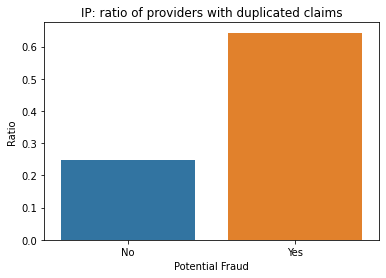

In [66]:
k = sns.barplot(x = c.index, y = 'ratio_provider_with_dup_claim', data = c)
# c.ratio_provider_with_dup_claim.plot(kind = 'bar', title = 'IP: ratio of providers with duplicated claims')
plt.ylabel('Ratio')
plt.xlabel('Potential Fraud')
plt.title('IP: ratio of providers with duplicated claims')
plt.savefig('../output/ip_provider_with_dup_claim_ratio.png')

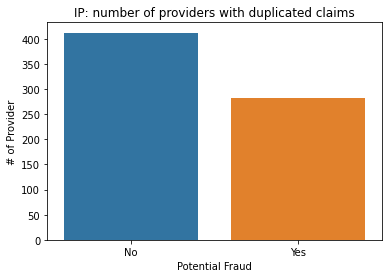

In [67]:
k = sns.barplot(x = c.index, y = 'provider_with_dup_claims', data = c)
# c.ratio_provider_with_dup_claim.plot(kind = 'bar', title = 'IP: ratio of providers with duplicated claims')
plt.ylabel('# of Provider')
plt.xlabel('Potential Fraud')
plt.title('IP: number of providers with duplicated claims')
plt.savefig('../output/ip_provider_with_dup_claim_number.png')

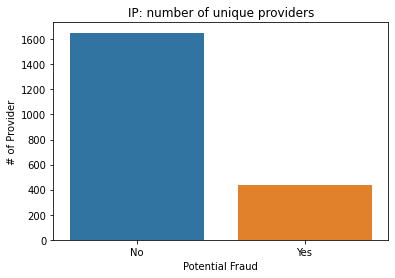

In [68]:
k = sns.barplot(x = c.index, y = 'unique_providers', data = c)
# c.ratio_provider_with_dup_claim.plot(kind = 'bar', title = 'IP: ratio of providers with duplicated claims')
plt.ylabel('# of Provider')
plt.xlabel('Potential Fraud')
plt.title('IP: number of unique providers')
plt.savefig('../output/ip_provider_unique_per_flag.png')

In [69]:
ip_claim_by_provider = df_ip.groupby('Provider').ClaimID.count().to_frame()
ip_claim_by_provider

,ClaimID
Provider,
PRV51001,5
PRV51003,62
PRV51007,3
PRV51008,2
PRV51011,1
PRV51021,29
PRV51023,9
PRV51024,9
PRV51025,13


In [70]:
temp = pd.DataFrame(df_ip.groupby(['PotentialFraud','Provider']))
temp.iloc[1,1]

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,ClaimDuration,HospitalDuration,TotalPaid,group,duplicated
29636,BENE16277,CLM53111,2009-05-28,2009-06-01,PRV51007,6000,PHY360635,PHY378129,NaN,2009-05-28,78097,1068.0,2009-06-01,085,3310,25000,42731,30000,4271,5990,V5861,0,0,0,8627.0,0.0,0.0,0.0,0.0,0.0,1926-06-01,NaN,2,1,0,1,460,12,12,0,0,1,1,1,1,0,0,1,1,0,6120,1068,200,50,No,4,4,7068.0,0.0,False
29637,BENE98446,CLM64487,2009-08-19,2009-08-24,PRV51007,10000,PHY406615,NaN,NaN,2009-08-19,29570,1068.0,2009-08-24,886,29620,4019,49390,4254,570,7295,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1936-04-01,NaN,1,1,Y,1,460,12,12,0,0,0,1,1,0,0,0,1,1,1,13000,2136,1480,890,No,5,5,11068.0,0.0,False
29638,BENE99552,CLM42710,2009-03-15,2009-03-22,PRV51007,3000,PHY360635,NaN,NaN,2009-03-15,29633,1068.0,2009-03-22,887,29622,79902,2859,7068,41400,7242,2724,3051,71690,0,0.0,0.0,0.0,0.0,0.0,0.0,1930-11-01,NaN,2,1,0,1,460,12,12,1,0,1,1,1,0,0,0,1,0,0,16010,3204,5560,470,No,7,7,4068.0,0.0,False


In [71]:
# sns.barplot(data = dup_ip_tally, x=dup_ip_tally.index, y = 'total_claim' )
# sns.barplot(data = dup_ip_tally, x=dup_ip_tally.index, y = 'duplicated_claim' )
# sns.barplot(data = dup_ip_tally, x=dup_ip_tally.index, y = 'duplicated_ratio' )

In [72]:
new = df_ip.groupby(['Provider', 'PotentialFraud']).apply(lambda x: x[x['duplicated'] == 'yes'].count())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [73]:
new.head()

,,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,ClaimDuration,HospitalDuration,TotalPaid,group,duplicated
Provider,PotentialFraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PRV51003,Yes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PRV51007,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PRV51008,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PRV51011,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [74]:
new2 = df_ip.groupby(['PotentialFraud', 'Provider']).duplicated.count()
new2.head(10)

PotentialFraud  Provider
No              PRV51001     5
                PRV51007     3
                PRV51008     2
                PRV51011     1
                PRV51023     9
                PRV51024     9
                PRV51025    13
                PRV51030    82
                PRV51031    28
                PRV51035     1
Name: duplicated, dtype: int64

In [75]:
test = df_ip.groupby(['PotentialFraud', 'Provider'])['Provider', 'ClaimID','group','duplicated']

<ipython-input-75-f5efd50cc83f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test = df_ip.groupby(['PotentialFraud', 'Provider'])['Provider', 'ClaimID','group','duplicated']


In [76]:
df_ip.groupby('PotentialFraud').apply(lambda x: x['duplicated'] == 'no').sum()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


0

In [77]:
## Q: generate new column
# dup_ip.apply(lambda x: x.index.tolist(), axis = 1)
# df_ip.apply(lambda x: x.index.tolist() in dup_ip_index, axis = 1)
# df_ip['duplicated'] = np.where(df_ip.index in dup_ip_index, 'yes', 'no')

#### duplicated claims per provider

In [137]:
df_ip_group = df_ip.groupby('Provider')

In [138]:
group_provider_claim_num = df_ip_group.group.count()
# display(group_provider_claim_num.shape)
group_provider_claim_num.head(2)

Provider
PRV51001     5
PRV51003    62
Name: group, dtype: int64

In [139]:
group_provider_dup_claim_num = df_ip_group.duplicated.sum()
display(group_provider_claim_num.shape)
group_provider_dup_claim_num.head(2)

(2092,)

Provider
PRV51001    0.0
PRV51003    1.0
Name: duplicated, dtype: float64

In [140]:
provider_dup_claim_num = pd.concat([group_provider_claim_num, group_provider_dup_claim_num], axis = 1)
provider_dup_claim_num.columns = ['ClaimNum', 'DupClaimNum']
provider_dup_claim_num['DupClaimRatio'] = provider_dup_claim_num['DupClaimNum'] / provider_dup_claim_num['ClaimNum']
provider_dup_claim_num['DupClaim'] = np.where(provider_dup_claim_num['DupClaimNum'] == 0, 'no', 'yes')
display(provider_dup_claim_num.shape)
display(provider_dup_claim_num.head())
provider_dup_claim_num.DupClaim.value_counts()

(2092, 4)

,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim
Provider,,,,
PRV51001,5,0.0,0.000000,no
PRV51003,62,1.0,0.016129,yes
PRV51007,3,0.0,0.000000,no
PRV51008,2,0.0,0.000000,no
PRV51011,1,0.0,0.000000,no


no     1397
yes     695
Name: DupClaim, dtype: int64

In [141]:
provider_dup_claim_num.to_csv('../output/ip_dup_claim_per_provider.csv')

In [142]:
provider_dup_claim_num.index.nunique()

2092

#### duplicated claim per provider from another state

In [143]:
dup_ip_group = dup_ip.groupby('Provider')

In [144]:
dup_ip_provider_state = dup_ip[['group', 'PotentialFraud','Provider','State']].sort_values(by = 'group')
display(dup_ip_provider_state.shape)
display(dup_ip_provider_state.head())

(1433, 4)

,group,PotentialFraud,Provider,State
22904,1,Yes,PRV51940,7
10448,1,Yes,PRV55209,34
23923,2,No,PRV55916,39
13514,2,Yes,PRV56560,45
11871,3,Yes,PRV53855,22


In [145]:
state_per_group = dup_ip_provider_state.groupby('group').State.unique().reset_index()
display(state_per_group.shape)
display(state_per_group.head(3))

state_per_group2 = state_per_group.set_index('group').State.apply(lambda x: len(x)).\
                    to_frame().reset_index().rename(columns={"State":"num_of_states"})
display(state_per_group2.shape)
display(state_per_group2.head(3))
state_per_group2.num_of_states.value_counts()

# state_per_group_dict = state_per_group.to_dict()

(704, 2)

,group,State
0,1,"[7, 34]"
1,2,"[39, 45]"
2,3,"[22, 11]"


(704, 2)

,group,num_of_states
0,1,2
1,2,2
2,3,2


2    651
1     38
3     10
4      4
5      1
Name: num_of_states, dtype: int64

In [146]:
# dup_ip_provider_state = dup_ip_provider_state.merge(state_per_group2, how='left', on='group')
display(dup_ip_provider_state.head(3))

,group,PotentialFraud,Provider,State
22904,1,Yes,PRV51940,7
10448,1,Yes,PRV55209,34
23923,2,No,PRV55916,39


In [147]:
state_per_group3 = dup_ip_provider_state.groupby('Provider').group.unique().reset_index()
display(state_per_group3.shape)
display(state_per_group3.head(3))

(695, 2)

,Provider,group
0,PRV51003,[593]
1,PRV51021,"[74, 645]"
2,PRV51023,[229]


In [148]:
dup_ip_provider_state.head(2)

,group,PotentialFraud,Provider,State
22904,1,Yes,PRV51940,7
10448,1,Yes,PRV55209,34


In [149]:
state_per_group3.group[1].tolist()

[74, 645]

In [150]:
display(state_per_group3.columns)
display(state_per_group3.iloc[1,0])
display(state_per_group3.iloc[1,1])

Index(['Provider', 'group'], dtype='object')

'PRV51021'

array([ 74, 645])

In [151]:
state_per_group_dict = state_per_group.set_index('group').T.to_dict()
display(state_per_group_dict[1])
state_per_group_dict[1]['State'].tolist()

{'State': array([ 7, 34])}

[7, 34]

In [152]:
def map_state_num(group_num_lst):
    ans = []
    lst = group_num_lst.tolist()
    for i in lst:
#         print('groups', i) # which dup claim groups belong to this Provider
#         print(type(i))
        new = state_per_group_dict[i]['State'].tolist() # states that the dup claims are from
#         print('new', new)
        ans.extend(new)
    ans = list(set(ans))
    return ans

k = map_state_num(state_per_group3.iloc[1,1])
k

[1, 5]

In [153]:
state_per_group3['DupClaimStates'] = state_per_group3.group.apply(map_state_num)
state_per_group3['DupClaimStatesNum'] = state_per_group3.DupClaimStates.apply(len)
state_per_group3['DupClaimMultiState'] = np.where(state_per_group3.DupClaimStatesNum <=1, 'no', 'yes')

In [154]:
state_per_group3.to_csv('../output/ip_dup_claim_state_num_per_provider.csv')
state_per_group3.head()

,Provider,group,DupClaimStates,DupClaimStatesNum,DupClaimMultiState
0,PRV51003,[593],"[1, 31]",2,yes
1,PRV51021,"[74, 645]","[1, 5]",2,yes
2,PRV51023,[229],"[1, 5]",2,yes
3,PRV51024,[541],"[1, 45]",2,yes
4,PRV51030,"[259, 282]","[16, 1, 5]",3,yes


In [155]:
provider_dup_claim_num.reset_index().Provider.count()

2092

In [156]:
display(provider_dup_claim_num.shape)
display(state_per_group3.shape)

(2092, 4)

(695, 5)

In [157]:
# dup_claims_ip = provider_dup_claim_num.reset_index().merge(state_per_group3, how='left', on='Provider')
# dup_claims_ip.to_csv('../output/provider_table_ip_dup_claims.csv')
# dup_claims_ip.head()

,Provider,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim,group,DupClaimStates,DupClaimStatesNum,DupClaimMultiState
0,PRV51001,5,0.0,0.000000,no,NaN,NaN,NaN,NaN
1,PRV51003,62,1.0,0.016129,yes,[593],"[1, 31]",2.0,yes
2,PRV51007,3,0.0,0.000000,no,NaN,NaN,NaN,NaN
3,PRV51008,2,0.0,0.000000,no,NaN,NaN,NaN,NaN
4,PRV51011,1,0.0,0.000000,no,NaN,NaN,NaN,NaN


### doctors shared by provider (for Patrice)

In [99]:
test = df_ip.groupby('Provider').AttendingPhysician.unique()
test.head()

Provider
PRV51001    [PHY340163, PHY346762, PHY383193, PHY402229]
PRV51003                          [PHY364445, PHY397381]
PRV51007                          [PHY360635, PHY406615]
PRV51008                          [PHY420919, PHY316314]
PRV51011                                     [PHY386036]
Name: AttendingPhysician, dtype: object

In [100]:
all_phy_list = []

In [101]:
new = df_ip.groupby('AttendingPhysician').Provider.size().reset_index()
new.head()

,AttendingPhysician,Provider
0,PHY311002,1
1,PHY311023,1
2,PHY311028,1
3,PHY311035,1
4,PHY311056,1


In [102]:
new2 = df_ip.groupby('AttendingPhysician').Provider.value_counts()
new2.head()

AttendingPhysician  Provider
PHY311002           PRV57495    1
PHY311023           PRV53432    1
PHY311028           PRV52181    1
PHY311035           PRV56449    1
PHY311056           PRV51165    1
Name: Provider, dtype: int64

### duplicated claim per provider from another provider

In [158]:
# dup_ip_group = dup_ip.groupby('Provider')
dup_ip_provider_prv = dup_ip[['group', 'PotentialFraud','Provider']].sort_values(by = 'group')
display(dup_ip_provider_prv.shape)
display(dup_ip_provider_prv.head())

(1433, 3)

,group,PotentialFraud,Provider
22904,1,Yes,PRV51940
10448,1,Yes,PRV55209
23923,2,No,PRV55916
13514,2,Yes,PRV56560
11871,3,Yes,PRV53855


In [159]:
prv_per_group = dup_ip_provider_prv.groupby('group').Provider.unique().reset_index()
display(prv_per_group.shape)
display(prv_per_group.head(3))

prv_per_group2 = prv_per_group.set_index('group').Provider.apply(lambda x: len(x)).\
                    to_frame().reset_index().rename(columns={"Provider":"ProviderNum"})
display(prv_per_group2.shape)
display(prv_per_group2.head(3))
prv_per_group2.ProviderNum.value_counts()

# state_per_group_dict = state_per_group.to_dict()

(704, 2)

,group,Provider
0,1,"[PRV51940, PRV55209]"
1,2,"[PRV55916, PRV56560]"
2,3,"[PRV53855, PRV52019]"


(704, 2)

,group,ProviderNum
0,1,2
1,2,2
2,3,2


2    672
1     15
3     12
4      4
5      1
Name: ProviderNum, dtype: int64

In [160]:
prv_per_group3 = dup_ip_provider_prv.groupby('Provider').group.unique().reset_index()
display(prv_per_group3.shape)
display(prv_per_group3.head(3))

(695, 2)

,Provider,group
0,PRV51003,[593]
1,PRV51021,"[74, 645]"
2,PRV51023,[229]


In [161]:
prv_per_group_dict = prv_per_group.set_index('group').T.to_dict()
prv_per_group_dict[1]

{'Provider': array(['PRV51940', 'PRV55209'], dtype=object)}

In [162]:
def map_prv_num(group_num_lst):
    ans = []
    lst = group_num_lst.tolist()
    for i in lst:
#         print('groups', i) # which dup claim groups belong to this Provider
#         print(type(i))
        new = prv_per_group_dict[i]['Provider'].tolist() # states that the dup claims are from
#         print('new', new)
        ans.extend(new)
    ans = list(set(ans))
    return ans

k = map_prv_num(prv_per_group3.iloc[1,1])
k

['PRV51021', 'PRV51809']

In [164]:
prv_per_group3['DupClaimProvider'] = prv_per_group3.group.apply(map_prv_num)
prv_per_group3['DupClaimProviderNum'] = prv_per_group3.DupClaimProvider.apply(len)
prv_per_group3['DupClaimMultiProvider'] = np.where(prv_per_group3.DupClaimProviderNum <=1, 'no', 'yes')
prv_per_group3.head()

,Provider,group,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider
0,PRV51003,[593],"[PRV51003, PRV54757]",2,yes
1,PRV51021,"[74, 645]","[PRV51021, PRV51809]",2,yes
2,PRV51023,[229],"[PRV51023, PRV51495]",2,yes
3,PRV51024,[541],"[PRV51024, PRV56685]",2,yes
4,PRV51030,"[259, 282]","[PRV52989, PRV51030, PRV51399]",3,yes


In [165]:
prv_per_group3.DupClaimProviderNum.value_counts()

2     389
3     130
4      70
5      33
6      24
7      12
8      11
1       6
9       5
10      4
11      3
12      2
16      2
19      1
13      1
14      1
20      1
Name: DupClaimProviderNum, dtype: int64

In [166]:
prv_per_group3[prv_per_group3.DupClaimMultiProvider == 'no'].DupClaimProviderNum.sum()

6

In [182]:
prv_per_group3.to_csv('../output/ip_dup_dupclaimdt_provider.csv')
dup_claims_ip.head()

,Provider,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim,DupClaimStates,DupClaimStatesNum,DupClaimMultiState,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider,group_x,DupClaimStartDt_x,DupClaimStartDtNum_x,DupClaimMultiStartDt_x,group_y,DupClaimStartDt_y,DupClaimStartDtNum_y,DupClaimMultiStartDt_y
0,PRV51001,5,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PRV51003,62,1.0,0.016129,yes,"[1, 31]",2.0,yes,"[PRV51003, PRV54757]",2.0,yes,[593],"[2009-08-25, 2009-05-25]",2.0,yes,[593],"[2009-08-25, 2009-05-25]",2.0,yes
2,PRV51007,3,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PRV51008,2,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PRV51011,1,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [168]:
# dup_claims_ip = dup_claims_ip.merge(prv_per_group3, how='left', on='Provider')
# dup_claims_ip.to_csv('../processed_data/provider_table_ip_dup_claims.csv')
# dup_claims_ip.head()

,Provider,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim,group_x,DupClaimStates,DupClaimStatesNum,DupClaimMultiState,group_y,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider
0,PRV51001,5,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PRV51003,62,1.0,0.016129,yes,[593],"[1, 31]",2.0,yes,[593],"[PRV51003, PRV54757]",2.0,yes
2,PRV51007,3,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PRV51008,2,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PRV51011,1,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### duplicated claim per provider from another date

In [169]:
# dup_ip_group = dup_ip.groupby('Provider')
dup_ip_provider_dt = dup_ip[['group', 'PotentialFraud','Provider', 'ClaimStartDt']].sort_values(by = 'group')
display(dup_ip_provider_dt.shape)
display(dup_ip_provider_dt.head())

(1433, 4)

,group,PotentialFraud,Provider,ClaimStartDt
22904,1,Yes,PRV51940,2009-04-19
10448,1,Yes,PRV55209,2009-12-14
23923,2,No,PRV55916,2009-01-08
13514,2,Yes,PRV56560,2009-06-16
11871,3,Yes,PRV53855,2009-09-07


In [170]:
dt_per_group = dup_ip_provider_dt.groupby('group').ClaimStartDt.unique().reset_index()
display(dt_per_group.shape)
display(dt_per_group.head(3))

dt_per_group2 = dt_per_group.set_index('group').ClaimStartDt.apply(lambda x: len(x)).\
                    to_frame().reset_index().rename(columns={"ClaimStartDt":"ClaimStartDtNum"})
display(dt_per_group2.shape)
display(dt_per_group2.head(3))
display(dt_per_group2.ClaimStartDtNum.value_counts())

dt_per_group3 = dup_ip_provider_dt.groupby('Provider').group.unique().reset_index()
display(dt_per_group3.shape)
display(dt_per_group3.head(5))

(704, 2)

,group,ClaimStartDt
0,1,"[2009-04-19, 2009-12-14]"
1,2,"[2009-01-08, 2009-06-16]"
2,3,"[2009-09-07, 2009-12-09]"


(704, 2)

,group,ClaimStartDtNum
0,1,2
1,2,2
2,3,2


2    671
1     16
3     13
4      3
5      1
Name: ClaimStartDtNum, dtype: int64

(695, 2)

,Provider,group
0,PRV51003,[593]
1,PRV51021,"[74, 645]"
2,PRV51023,[229]
3,PRV51024,[541]
4,PRV51030,"[259, 282]"


In [171]:
dt_per_group_dict = dt_per_group.set_index('group').T.to_dict()
display(dt_per_group_dict[1])
dt_per_group_dict[1]['ClaimStartDt'].tolist()

{'ClaimStartDt': array(['2009-04-19', '2009-12-14'], dtype=object)}

['2009-04-19', '2009-12-14']

In [172]:
def map_dt_num(group_num_lst):
    ans = []
    lst = group_num_lst.tolist()
    for i in lst:
#         print('groups', i) # which dup claim groups belong to this Provider
#         print(type(i))
        new = dt_per_group_dict[i]['ClaimStartDt'].tolist() # states that the dup claims are from
#         print('new', new)
        ans.extend(new)
    ans = list(set(ans))
    return ans

k = map_dt_num(dt_per_group3.iloc[1,1])
k

['2009-08-03', '2009-09-28', '2009-01-17']

In [173]:
dt_per_group3['DupClaimStartDt'] = dt_per_group3.group.apply(map_dt_num)
dt_per_group3['DupClaimStartDtNum'] = dt_per_group3.DupClaimStartDt.apply(len)
dt_per_group3['DupClaimMultiStartDt'] = np.where(dt_per_group3.DupClaimStartDtNum <=1, 'no', 'yes')

In [174]:
display(dt_per_group3.head())
# display(dt_per_group3.DupClaimStartDtNum.value_counts())

,Provider,group,DupClaimStartDt,DupClaimStartDtNum,DupClaimMultiStartDt
0,PRV51003,[593],"[2009-08-25, 2009-05-25]",2,yes
1,PRV51021,"[74, 645]","[2009-08-03, 2009-09-28, 2009-01-17]",3,yes
2,PRV51023,[229],"[2009-03-21, 2009-02-05]",2,yes
3,PRV51024,[541],"[2009-10-07, 2009-07-02]",2,yes
4,PRV51030,"[259, 282]","[2009-05-02, 2009-10-30, 2009-01-31, 2009-03-04]",4,yes


In [180]:
# dup_claims_ip = dup_claims_ip.merge(dt_per_group3, how='left', on='Provider')
# dup_claims_ip.to_csv('../processed_data/provider_table_ip_dup_claims.csv')
# dup_claims_ip.head(2)

,Provider,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim,DupClaimStates,DupClaimStatesNum,DupClaimMultiState,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider,group_x,DupClaimStartDt_x,DupClaimStartDtNum_x,DupClaimMultiStartDt_x,group_y,DupClaimStartDt_y,DupClaimStartDtNum_y,DupClaimMultiStartDt_y
0,PRV51001,5,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PRV51003,62,1.0,0.016129,yes,"[1, 31]",2.0,yes,"[PRV51003, PRV54757]",2.0,yes,[593],"[2009-08-25, 2009-05-25]",2.0,yes,[593],"[2009-08-25, 2009-05-25]",2.0,yes


In [184]:
# dup_claims_ip.drop(['group_x', 'group_y'], axis = 1, inplace=True)

In [ ]:
# dup_claims_ip = provider_dup_claim_num.reset_index().merge(state_per_group3, how='left', on='Provider')

### Data Export

In [207]:
display(provider_dup_claim_num.shape)
display(provider_dup_claim_num.head(1))
display(state_per_group3.shape)
display(state_per_group3.head(1))
display(prv_per_group3.shape)
display(prv_per_group3.head(1))
display(dt_per_group3.shape)
display(dt_per_group3.head(1))

(2092, 4)

,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim
Provider,,,,
PRV51001,5,0.0,0.0,no


(695, 5)

,Provider,group,DupClaimStates,DupClaimStatesNum,DupClaimMultiState
0,PRV51003,[593],"[1, 31]",2,yes


(695, 5)

,Provider,group,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider
0,PRV51003,[593],"[PRV51003, PRV54757]",2,yes


(695, 5)

,Provider,group,DupClaimStartDt,DupClaimStartDtNum,DupClaimMultiStartDt
0,PRV51003,[593],"[2009-08-25, 2009-05-25]",2,yes


In [232]:
# dup_claims_ip = pd.concat([state_per_group3.set_index('Provider'), prv_per_group3.set_index('Provider'), dt_per_group3.set_index('Provider')],
#                           keys='Provider', axis =1, join='outer')
# display(dup_claims_ip.shape)
# dup_claims_ip.head()

In [242]:
%reset dup_claims_ip

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  dup_claims_ip, please run `%reset?` for details


In [243]:
dup_claims_ip0 = state_per_group3.merge(prv_per_group3, how='inner', on='Provider')
dup_claims_ip = dup_claims_ip0.merge(dt_per_group3, how='inner', on='Provider')
dup_claims_ip.drop(['group_x','group_y'], axis=1, inplace=True)

In [244]:
dup_claims_ip.head()

,Provider,DupClaimStates,DupClaimStatesNum,DupClaimMultiState,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider,group,DupClaimStartDt,DupClaimStartDtNum,DupClaimMultiStartDt
0,PRV51003,"[1, 31]",2,yes,"[PRV51003, PRV54757]",2,yes,[593],"[2009-08-25, 2009-05-25]",2,yes
1,PRV51021,"[1, 5]",2,yes,"[PRV51021, PRV51809]",2,yes,"[74, 645]","[2009-08-03, 2009-09-28, 2009-01-17]",3,yes
2,PRV51023,"[1, 5]",2,yes,"[PRV51023, PRV51495]",2,yes,[229],"[2009-03-21, 2009-02-05]",2,yes
3,PRV51024,"[1, 45]",2,yes,"[PRV51024, PRV56685]",2,yes,[541],"[2009-10-07, 2009-07-02]",2,yes
4,PRV51030,"[16, 1, 5]",3,yes,"[PRV52989, PRV51030, PRV51399]",3,yes,"[259, 282]","[2009-05-02, 2009-10-30, 2009-01-31, 2009-03-04]",4,yes


In [224]:
provider_dup_claim_num.reset_index().head(3)

,Provider,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim
0,PRV51001,5,0.0,0.000000,no
1,PRV51003,62,1.0,0.016129,yes
2,PRV51007,3,0.0,0.000000,no


In [249]:
provider_dup_ip = provider_dup_claim_num.reset_index().merge(dup_claims_ip, how='left', on='Provider')
display(provider_dup_ip.head(3))

,Provider,ClaimNum,DupClaimNum,DupClaimRatio,DupClaim,DupClaimStates,DupClaimStatesNum,DupClaimMultiState,DupClaimProvider,DupClaimProviderNum,DupClaimMultiProvider,group,DupClaimStartDt,DupClaimStartDtNum,DupClaimMultiStartDt
0,PRV51001,5,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PRV51003,62,1.0,0.016129,yes,"[1, 31]",2.0,yes,"[PRV51003, PRV54757]",2.0,yes,[593],"[2009-08-25, 2009-05-25]",2.0,yes
2,PRV51007,3,0.0,0.000000,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [250]:
provider_dup_ip.to_csv('../processed_data/provider_dup_ip.csv', index = False)
display(df_ip.Provider.nunique())
display(provider_dup_ip.shape)

2092

(2092, 15)